In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import xgboost as xgb


In [3]:
# ระบุ path ไฟล์ csv
csv_paths = ["./cafethai_prices.csv"]

for p in csv_paths:
    if os.path.exists(p):
        path = p
        break
else:
    raise FileNotFoundError("ไม่พบไฟล์ cafethai_prices.csv")

df = pd.read_csv(path)

# ตรวจสอบคอลัมน์
df.columns = [c.strip() for c in df.columns]
print("Columns:", df.columns.tolist())

# แปลงคอลัมน์วันที่
date_col = [c for c in df.columns if "date" in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
df = df.dropna(subset=[date_col]).rename(columns={date_col:"date"})

# ตั้งชื่อคอลัมน์มาตรฐาน
if "coffee_name" not in df.columns and "item" in df.columns:
    df = df.rename(columns={"item":"coffee_name"})

if "count" not in df.columns:
    df["count"] = 1

if "money" not in df.columns:
    df["money"] = np.nan

print("Data Range:", df["date"].min(), "→", df["date"].max())
print("Unique drinks:", df["coffee_name"].nunique())

df.head()


Columns: ['date', 'time', 'cash_type', 'coffee_name', 'money']
Data Range: 2023-03-01 00:00:00 → 2025-04-30 00:00:00
Unique drinks: 8


,date,time,cash_type,coffee_name,money,count
0,2023-03-01,08:04:19,card,Latte,75,1
1,2023-03-01,08:08:54,cash,Americano with Milk,70,1
2,2023-03-01,08:09:03,card,Cappuccino,75,1
3,2023-03-01,08:10:26,cash,Cappuccino,75,1
4,2023-03-01,08:15:37,cash,Cappuccino,75,1


Top drinks: ['Latte', 'Americano with Milk', 'Cappuccino', 'Americano', 'Cortado']


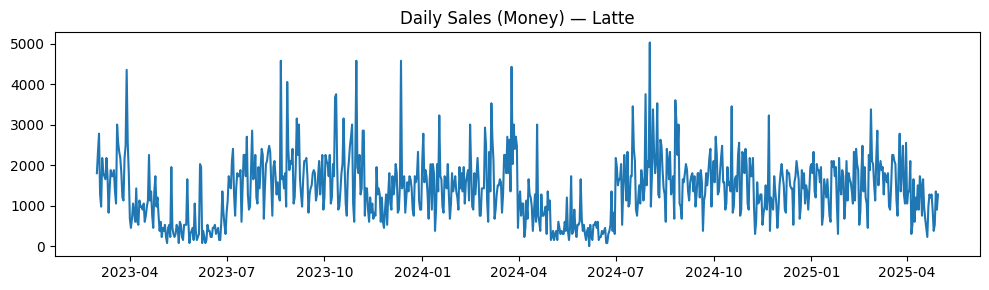

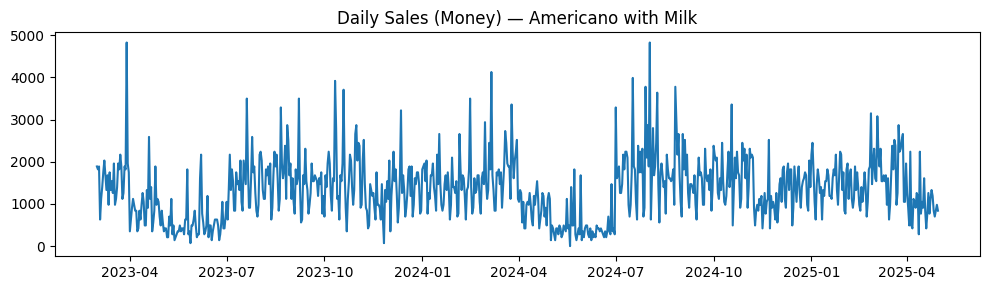

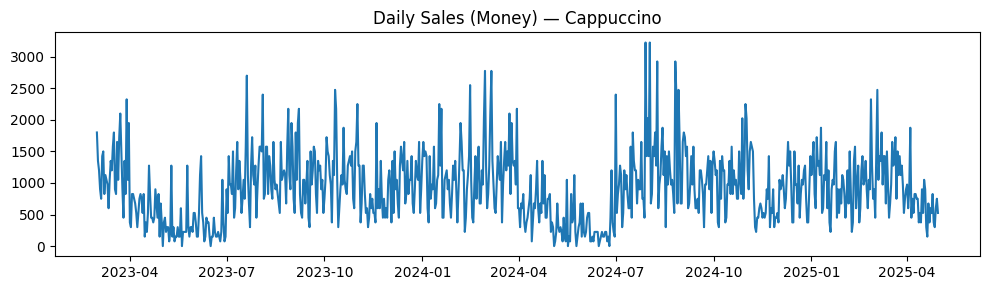

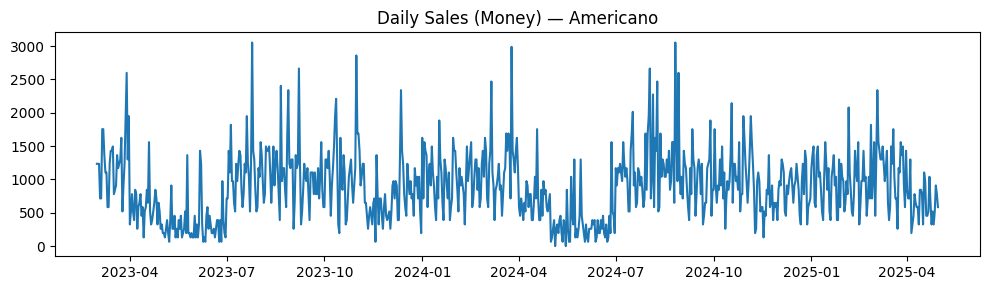

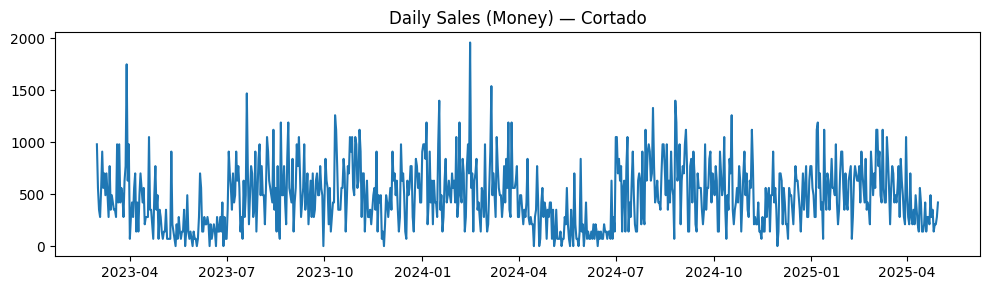

In [4]:
agg = df.groupby(["date","coffee_name"]).agg(
    money_total=("money","sum"),
    count_total=("count","sum")
).reset_index()

agg = agg.sort_values(["coffee_name","date"]).reset_index(drop=True)

# ดูเครื่องดื่มยอดนิยม
top_drinks = agg.groupby("coffee_name")["money_total"].sum().sort_values(ascending=False).head(5).index.tolist()
print("Top drinks:", top_drinks)

# plot ตัวอย่าง
for drink in top_drinks:
    tmp = agg[agg["coffee_name"]==drink].set_index("date").resample("D").sum().fillna(0)
    plt.figure(figsize=(10,3))
    plt.plot(tmp.index, tmp["money_total"])
    plt.title(f"Daily Sales (Money) — {drink}")
    plt.tight_layout()
    plt.show()


In [5]:
def create_features(ts_df, date_col="date", target_col="money_total"):
    df_local = ts_df[[date_col,target_col]].copy()
    df_local = df_local.set_index(date_col).asfreq("D").fillna(0).reset_index()

    # Date features
    df_local["dayofweek"] = df_local["date"].dt.weekday
    df_local["month"] = df_local["date"].dt.month
    df_local["year"] = df_local["date"].dt.year
    df_local["is_weekend"] = df_local["dayofweek"].isin([5,6]).astype(int)

    # Lag features
    for l in [7,14,21,28]:
        df_local[f"lag_{l}"] = df_local[target_col].shift(l).fillna(0)

    # Rolling mean
    df_local["rmean_7"] = df_local[target_col].rolling(7).mean().shift(1).fillna(0)
    df_local["rmean_14"] = df_local[target_col].rolling(14).mean().shift(1).fillna(0)

    return df_local


In [6]:
HORIZON = 60
predictions = []
metrics = []

for drink in agg["coffee_name"].unique():
    print("\nProcessing:", drink)
    ts = agg[agg["coffee_name"]==drink][["date","money_total","count_total"]]

    for target in ["money_total","count_total"]:
        if ts[target].sum()==0:
            continue

        feats = create_features(ts, target_col=target).sort_values("date")

        # train/test split
        if len(feats) > HORIZON+30:
            train = feats.iloc[:-HORIZON]
            test = feats.iloc[-HORIZON:]
        else:
            split = int(len(feats)*0.8)
            train, test = feats.iloc[:split], feats.iloc[split:]

        X_train = train.drop(columns=["date",target])
        y_train = train[target]
        X_test = test.drop(columns=["date",target])
        y_test = test[target]

        # Train model
        model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
        model.fit(X_train,y_train)

        # Backtest
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test,y_pred)
        print(f"  {target} MAE: {mae:.2f}")
        metrics.append({"drink":drink,"target":target,"mae":mae})

        # Forecast future 60 days
        last_date = feats["date"].max()
        future_dates = pd.date_range(start=last_date+timedelta(days=1), periods=HORIZON, freq="D")

        hist = feats[["date",target]].set_index("date").copy()
        full = pd.concat([hist, pd.DataFrame(index=future_dates)])
        full[target] = full[target].fillna(0)

        future_preds = []
        for d in future_dates:
            row = {
                "dayofweek": d.weekday(),
                "month": d.month,
                "year": d.year,
                "is_weekend": int(d.weekday() in [5,6])
            }
            for l in [7,14,21,28]:
                lag_date = d - timedelta(days=l)
                row[f"lag_{l}"] = full.loc[lag_date,target] if lag_date in full.index else 0
            row["rmean_7"] = full.loc[full.index < d, target].tail(7).mean()
            row["rmean_14"] = full.loc[full.index < d, target].tail(14).mean()

            Xf = pd.DataFrame([row])
            pred = float(max(0, model.predict(Xf)[0]))
            full.loc[d,target] = pred
            future_preds.append({"date":d,"drink":drink,"target":target,"prediction":pred})

        predictions.extend(future_preds)



Processing: Americano
  money_total MAE: 290.75
  count_total MAE: 4.47

Processing: Americano with Milk
  money_total MAE: 348.53
  count_total MAE: 4.98

Processing: Cappuccino
  money_total MAE: 273.83
  count_total MAE: 3.65

Processing: Cocoa
  money_total MAE: 115.55
  count_total MAE: 2.31

Processing: Cortado
  money_total MAE: 174.54
  count_total MAE: 2.49

Processing: Espresso
  money_total MAE: 91.98
  count_total MAE: 1.42

Processing: Hot Chocolate
  money_total MAE: 142.42
  count_total MAE: 2.85

Processing: Latte
  money_total MAE: 326.09
  count_total MAE: 4.35


In [7]:
pred_df = pd.DataFrame(predictions)
pred_pivot = pred_df.pivot_table(index=["date","drink"], columns="target", values="prediction").reset_index()
pred_pivot.columns.name = None
pred_pivot.head(15)


,date,drink,count_total,money_total
0,2025-05-01,Americano,8.260898,536.958923
1,2025-05-01,Americano with Milk,11.693254,818.527527
2,2025-05-01,Cappuccino,6.586544,493.990387
3,2025-05-01,Cocoa,5.770888,288.544525
4,2025-05-01,Cortado,2.712100,189.846985
5,2025-05-01,Espresso,1.858855,120.825645
6,2025-05-01,Hot Chocolate,5.873672,293.683563
7,2025-05-01,Latte,11.530067,864.755920
8,2025-05-02,Americano,7.635182,496.287079
9,2025-05-02,Americano with Milk,14.480412,1013.628540


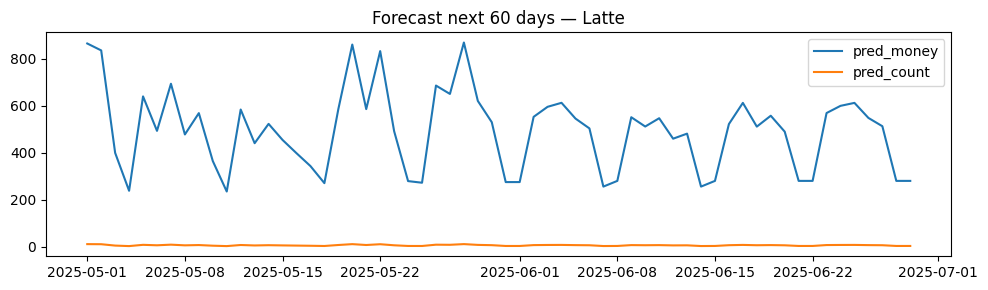

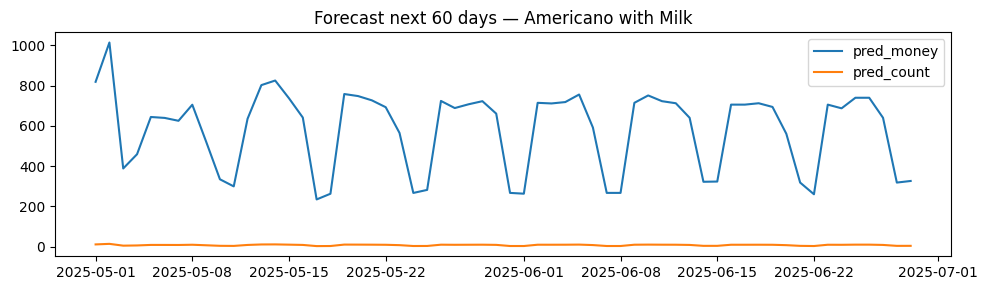

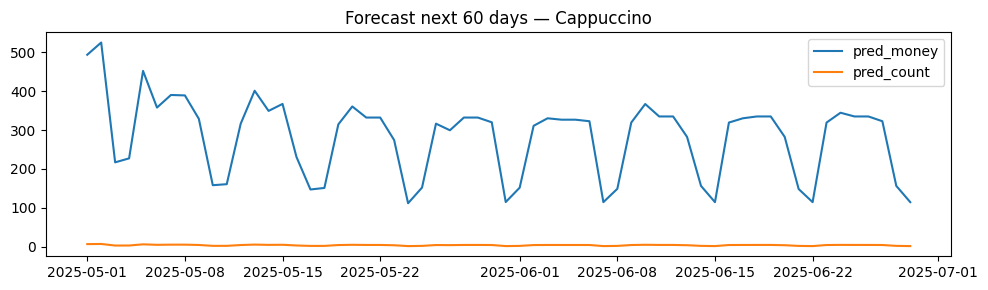

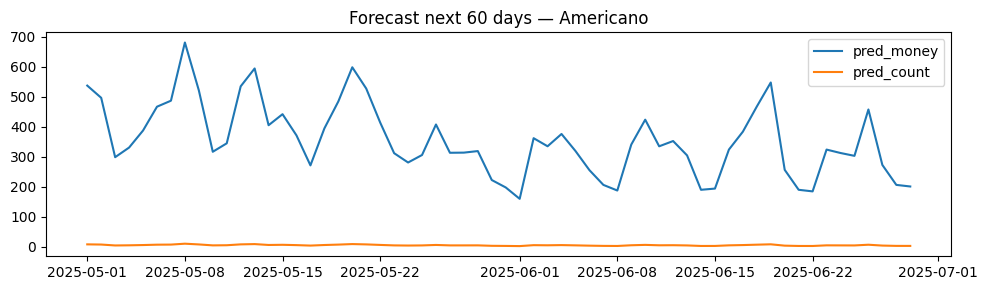

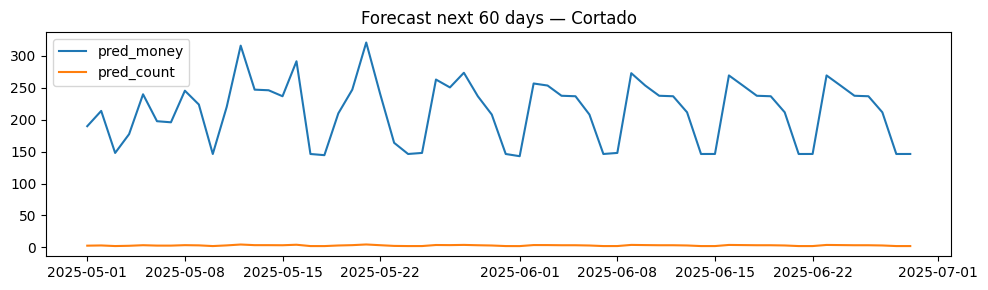

In [8]:
for drink in top_drinks:
    sub = pred_pivot[pred_pivot["drink"]==drink].set_index("date").sort_index()
    if sub.empty: continue
    plt.figure(figsize=(10,3))
    if "money_total" in sub.columns:
        plt.plot(sub.index, sub["money_total"], label="pred_money")
    if "count_total" in sub.columns:
        plt.plot(sub.index, sub["count_total"], label="pred_count")
    plt.title(f"Forecast next {HORIZON} days — {drink}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
metrics_df = pd.DataFrame(metrics)
metrics_df.sort_values("mae").head(10)


,drink,target,mae
11,Espresso,count_total,1.415102
7,Cocoa,count_total,2.311027
9,Cortado,count_total,2.493431
13,Hot Chocolate,count_total,2.848496
5,Cappuccino,count_total,3.651077
15,Latte,count_total,4.347918
1,Americano,count_total,4.473034
3,Americano with Milk,count_total,4.979051
10,Espresso,money_total,91.981617
6,Cocoa,money_total,115.551363
